In [2]:
library(Seurat)
library(Matrix)
#library(DoubletDecon)
library(fields)
library(KernSmooth)
library(ROCR)
library(modes)
library(gplots)
library(ggplot2)

Loading required package: spam
Loading required package: dotCall64
Loading required package: grid
Spam version 2.2-2 (2019-03-07) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following object is masked from ‘package:Matrix’:

    det

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

Loading required package: maps
See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 
KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009
Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



In [5]:
#library(devtools)
#options(unzip = "internal")
#devtools::install_github('EDePasquale/DoubletDecon')


Loading required package: usethis


✔  checking for file ‘/scratch/10495226.helix-master/RtmpY8Nzl0/remotese5152715dd8b/EDePasquale-DoubletDecon-116d7c7/DESCRIPTION’ (541ms)
─  preparing ‘DoubletDecon’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files
─  checking for empty or unneeded directories
─  looking to see if a ‘data/datalist’ file should be added
─  building ‘DoubletDecon_1.0.2.tar.gz’
   


Installing package into ‘/home/danaco/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)
Warning message in i.p(...):
“installation of package ‘/scratch/10495226.helix-master/RtmpY8Nzl0/filee51574170ca6/DoubletDecon_1.0.2.tar.gz’ had non-zero exit status”

In [3]:
source("/projects/ucar-lab/danaco/bncmrk-dblts/R/Seurat_Pre_Process2.R")

In [4]:
expressionFile="/projects/ucar-lab/danaco/bncmrk-dblts/DoubletDecon/input/Four.Cell.12.HTO/Four.Cell.12.HTO.preprocessed.seurat.for.DoubDec.counts.txt"
genesFile="/projects/ucar-lab/danaco/bncmrk-dblts/DoubletDecon/input/Four.Cell.12.HTO/Four.Cell.12.HTO.preprocessed.seurat.for.DoubDec.Top50Genes.txt"
clustersFile="/projects/ucar-lab/danaco/bncmrk-dblts/DoubletDecon/input/Four.Cell.12.HTO/Four.Cell.12.HTO.preprocessed.seurat.for.DoubDec.Cluster.txt"

In [61]:
expressionFile="/projects/ucar-lab/danaco/bncmrk-dblts/DoubletDecon/input/CZI.PBMC/CZI.PBMC.8.preprocessed.seurat.for.DoubDec.counts.txt"
genesFile="/projects/ucar-lab/danaco/bncmrk-dblts/DoubletDecon/input/CZI.PBMC/CZI.PBMC.8.preprocessed.seurat.for.DoubDec.Top50Genes.txt"
clustersFile="/projects/ucar-lab/danaco/bncmrk-dblts/DoubletDecon/input/CZI.PBMC/CZI.PBMC.8.preprocessed.seurat.for.DoubDec.Cluster.txt"



newFiles=Seurat_Pre_Process2(expressionFile, genesFile, clustersFile)


In [10]:
newFiles=Seurat_Pre_Process2(expressionFile, genesFile, clustersFile)
 

#expression=read.table(expressionFile, sep="\t",header=T, row.names=1)
 #colnames(expression)=gsub(x=colnames(expression),
#pattern="X",replacement="") 
#genes=read.table(genesFile, sep="\t",header=T, row.names=1)
 # clusters=read.table(clustersFile, sep="\t",header=T)

In [62]:
rawData=newFiles$newExpressionFile
groups=newFiles$newGroupsFile
log_file_name=paste0("bebe",".log")
log_con <- file(log_file_name)


In [63]:
Renumber<-function(x){
  y=as.integer(as.factor(as.numeric(x)))
  return(y)
}


Clean_Up_Input<-function(rawData, groups, rowClusters=NULL, log_file_name){

  if(row.names(rawData)[1] %in% "column_clusters-flat" && (colnames(rawData)[1] %in% "row_clusters.flat" || colnames(rawData)[1] %in% "row_clusters-flat")){ #standard ICGS, contains column and row clusters

    rawDataStrip=rawData[-1,]
    processed=rbind(c(NA,groups[,1]),rawDataStrip) #replace with provided groups file
    row.names(processed)[1]="column_clusters-flat"

  }else if(row.names(rawData)[1] %in% "column_clusters-flat"){ #only has column clusters

    rawDataStrip=rawData[-1,]
    processed=rbind(groups[,1],rawDataStrip) #replace with provided groups file
    row.names(processed)[1]="column_clusters-flat"
    processed=cbind(rep(NA, nrow(processed)), processed)
    colnames(processed)[1]="row_clusters.flat"

  }else if(colnames(rawData)[1] %in% "row_clusters.flat" || colnames(rawData)[1] %in% "row_clusters-flat"){ #only has row clusters

    processed=rbind(c(NA,groups[,1]),rawData) #replace with provided groups file
    row.names(processed)[1]="column_clusters-flat"

  }else{ #has no column or row clusters

    processed=rbind(groups[,1],rawData) #replace with provided groups file
    row.names(processed)[1]="column_clusters-flat"
    processed=cbind(rep(NA, nrow(processed)), processed)
    colnames(processed)[1]="row_clusters.flat"

  }
  if(is.null(rowClusters)==FALSE){
    #attach the row clusters information
    processed[2:nrow(processed),1]=rowClusters
  }

  rownames(groups)=colnames(processed)[2:ncol(processed)] #because row and column names with special characters can cause problems in R

  #Renumber to avoid non-consecutive cluster identifications in the data and groups files
  groups[,1]=Renumber(groups[,1])
  processed[1,2:ncol(processed)]=Renumber(processed[1,2:ncol(processed)])
  if(is.na(processed[2,1])==FALSE){
    processed[2:nrow(processed),1]=Renumber(processed[2:nrow(processed),1])
  }

  cat(paste0(ncol(processed)-2, " samples after processing"), file=log_file_name, append=TRUE, sep="\n")
  cat(paste0(nrow(processed)-2, " genes after processing"), file=log_file_name, append=TRUE, sep="\n")

  return(list(processed=processed, groups=groups))
}



In [64]:
data=Clean_Up_Input(rawData, groups, log_file_name=log_file_name)
 og_processed_data=data$processed
  groups=data$groups

In [65]:
    data=data$processed


In [66]:
Blacklist_Groups<-function(data, groups, rhop, centroid_flag, log_file_name){

  #Step 1: calculate medoids
  medoids=data.frame(rep(NA,nrow(data)-1))
  clusters=length(unique(groups[,1]))
  for(cluster in 1:clusters){
    if(centroid_flag==TRUE){
      medoids=cbind(medoids,apply(data[2:nrow(data),which(data[1,]==cluster)],1,mean))
    }else{
      medoids=cbind(medoids,apply(data[2:nrow(data),which(data[1,]==cluster)],1,median))
    }
  }
  medoids=medoids[,-1]
  colnames(medoids)=unique(groups[,2])

  #Step 2: medoid correlations
  cormedoids=cor(medoids, method="pearson")

  #Step 3: create blacklist (binary correlation table between medoids)
  blacklist=data.frame(matrix(ncol=ncol(medoids),nrow=ncol(medoids)))
  cutoff=mean(cormedoids)+(rhop)*sd(cormedoids) #based on mean + 1SD * user provided multiplier
  for(rrow in 1:nrow(cormedoids)){
    for(ccol in 1:ncol(cormedoids)){
      if(cormedoids[rrow,ccol]>cutoff){
        blacklist[rrow,ccol]=1
      }else{
        blacklist[rrow,ccol]=0
      }
    }
  }
  blacklist_original_order=blacklist #keep original order with no names so I can pull the correct clusters out when trying to make medoids
  row.names(blacklist)=row.names(cormedoids)
  colnames(blacklist)=row.names(cormedoids)

  #Step 4: make blacklist heatmap
  BLheatmap=heatmap.2(as.matrix(blacklist_original_order),
                      Colv=TRUE, # clustering of columns
                      Rowv=TRUE, # clustering of rows
                      xlab = "Cell Types", #x axis title
                      ylab =  "Cell Types", #y axis title
                      trace="none",
                      main = "Cluster Merge") #main title
  blacklist_original_order=blacklist_original_order[BLheatmap$rowInd,BLheatmap$colInd]
  blacklist=blacklist[BLheatmap$rowInd,BLheatmap$colInd]

  #Step 5: make new medoids
  blacklistCluster=try(mcl(blacklist, addLoops=FALSE)$Cluster)
  if(class(blacklistCluster) == "try-error"){
    print("Unable to perform mcl function for blacklist clustering, please try a different rhop.")
    stop()
  }
  i=-1 #if the cluster is 0 (meaning no combining) change the name of the cluster to make it unique
  for(cluster in 1:length(blacklistCluster)){
    if(blacklistCluster[cluster]==0){
      blacklistCluster[cluster]=i
      i=i-1
    }
  }
  uniquelist=unique(blacklistCluster) #list of unique clusters
  nunique=length(uniquelist) #number of unique clusters
  newMedoids=data.frame(matrix(ncol=nunique, nrow=(nrow(data)-1)))
  for(cluster in 1:nunique){ #for each new cluster, assign medoid to new data.frame
    temp=which(blacklistCluster==uniquelist[cluster])
    if(centroid_flag==TRUE){
      newMedoids[,cluster]=apply(data[2:nrow(data),(data[1,] %in% rownames(blacklist_original_order)[temp])],1,mean) #this is where the original order is critical
    }else{
      newMedoids[,cluster]=apply(data[2:nrow(data),(data[1,] %in% rownames(blacklist_original_order)[temp])],1,median) #this is where the original order is critical
    }
    colnames(newMedoids)[cluster]=paste(rownames(blacklist)[temp], collapse="-") #need to give the columns meaningful names (combination names of combined clusters)

  }
  row.names(newMedoids)=row.names(data)[2:nrow(data)]

  #Step 6: make new combined groups file
  newGroups=data.frame(matrix(ncol=ncol(groups)+1, nrow=1))
  for(cluster in 1:nunique){
    temp=which(blacklistCluster==uniquelist[cluster])
    temp1.5=as.integer(row.names(blacklist_original_order)[temp])
    temp2=groups[groups[,1] %in% temp1.5,]
    temp3=cbind(temp2,rep(paste(rownames(blacklist)[temp], collapse="-"), nrow(temp2)))
    colnames(temp3)=colnames(newGroups)
    newGroups=rbind(newGroups, temp3)
  }
  newGroups=newGroups[-1,]
  newGroups[,2]=as.integer(as.factor(newGroups[,3]))
  newGroups=newGroups[,-1]

  cat(paste0("New blacklisted clusters: ", paste(unique(newGroups[,2]), sep="' '", collapse=", ")), file=log_file_name, append=TRUE, sep="\n")


  return(list(newMedoids=newMedoids, newGroups=newGroups))
}

[1] "Unable to perform mcl function for blacklist clustering, please try a different rhop."


ERROR: Error in Blacklist_Groups(data, groups, rhop, centroid_flag, log_file_name): 


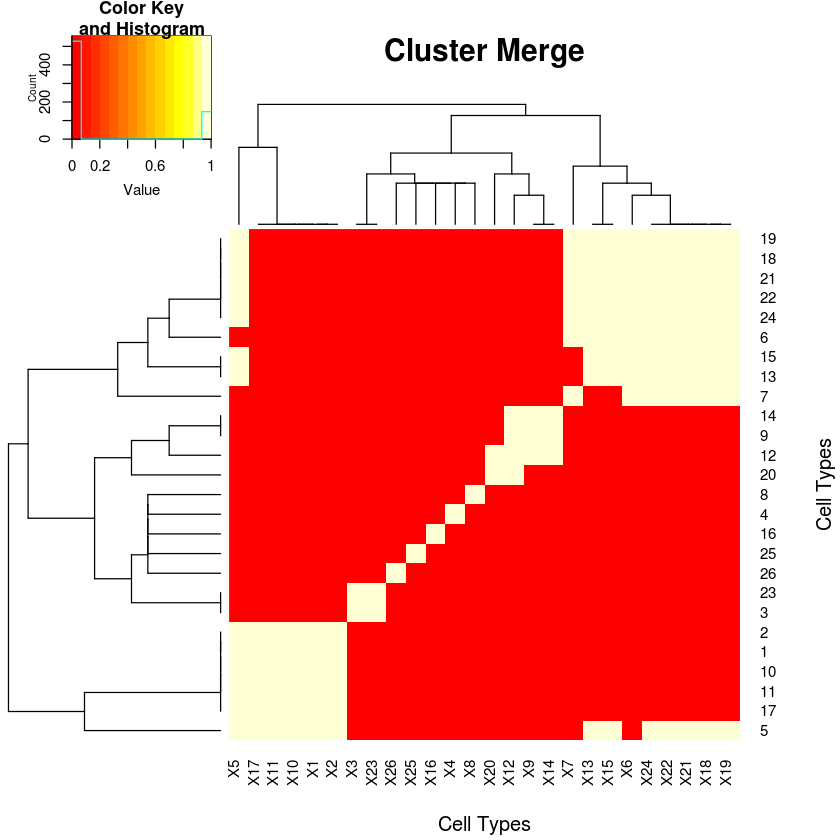

In [70]:
rhop=0.75
centroids=TRUE
 if(centroids==TRUE){
    centroid_flag=TRUE
  }

  BL=Blacklist_Groups(data, groups, rhop, centroid_flag, log_file_name)


In [11]:
library(ggplot2)
library(gplots)

In [26]:
colnames(data)[2:6
              ]

[1] "GTGCAGCTCTTCGGTC" "GTGAAGGAGGGCTCTC" "AGGGAGTTCTGGCGTG" "CGGCTAGGTCAAAGCG"
[5] "AACTCTTAGACCGGAT"

In [24]:
dim(groups)

[1] 23208     2

In [ ]:
tail(data)

In [38]:
kilastirs=read.table(clustersFile, sep="\t",header=T)

In [50]:
#summary(as.factor(groups[,1]))
clst_ids=unname(groups[,1])<22
groups_=groups[clst_ids,]
sbs_brcds=rownames(groups_)
data_=cbind2(data[,1],data[,sbs_brcds])

In [51]:
dim(data_)
dim(groups_)

[1]   410 29093

[1] 29092     2

In [73]:
bebe=unname(bebe)

In [43]:
head(data)

,row_clusters-flat,6.Sample_AAACCTGGTACTCGCG,6.Sample_AAACCTGGTCGCATAT,6.Sample_AAACCTGGTTACGACT,6.Sample_AAACCTGTCAGGATCT,6.Sample_AAACCTGTCTCGGACG,6.Sample_AAACGGGAGAATTGTG,6.Sample_AAACGGGAGCTGCAAG,6.Sample_AAACGGGAGTTAGGTA,6.Sample_AAACGGGCAAAGCAAT,⋯,6.Sample_TCTCTAAAGTGGTAGC,6.Sample_TGAAAGACATTCTTAC,6.Sample_TGAGAGGCAAGCGTAG,6.Sample_TGAGCATCAAGTTGTC,6.Sample_TGCACCTGTCCGAAGA,6.Sample_TGTGTTTGTATATCCG,6.Sample_TGTGTTTGTCTCATCC,6.Sample_TTGACTTAGGCTAGAC,6.Sample_TTTGGTTGTGTGCCTG,6.Sample_TTTGTCAAGAAGGGTA
column_clusters-flat,NA,1.0000000,1.000000,1,1,1,1.0000000,1,1,1.000000,⋯,29.000000,29.000000,29.0000000,29.0000000,29.0000000,29.0000000,29.000000,29.000000,29.000000,29.0000000
CD63,1,0.0000000,0.000000,0,0,0,0.5638287,0,0,0.000000,⋯,1.393655,1.185452,0.5638287,0.9221839,1.9543184,1.3936554,1.565892,2.233371,1.840822,0.9221839
TYROBP,1,0.0000000,0.000000,0,0,0,0.0000000,0,0,0.000000,⋯,2.067725,1.875710,2.6955478,2.3673931,2.4891398,2.0677251,2.695548,1.763835,1.976319,2.3673931
DYNLL1,1,0.0000000,0.547207,0,0,0,0.0000000,0,0,0.000000,⋯,0.898875,0.898875,0.5472070,0.8988750,1.9209367,1.1585328,1.535166,1.680923,0.547207,1.3644769
TYMP,1,0.9405922,0.000000,0,0,0,0.0000000,0,0,0.577034,⋯,1.206643,1.980448,1.2066432,0.0000000,1.2066432,0.5770340,1.980448,1.737742,1.416580,0.0000000
CLIC1,1,0.0000000,0.000000,0,0,0,0.0000000,0,0,0.000000,⋯,1.375555,1.168746,2.0352107,1.9336273,0.5534932,0.5534932,1.546837,1.546837,1.168746,0.5534932


In [47]:
summary(as.factor(data[,1]))

1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
  50   25   36   37   26   27    7   17   10    1   11   10    7   13   29   10 
  17   18   19   20   21 NA's 
   2   18    7   45   21    1

In [48]:
dim(data)

[1]   410 32139

In [49]:
dim(groups)

[1] 32138     2